In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install pyyaml h5py
!pip install plot-keras-history

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from plot_keras_history import show_history, plot_history

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import preprocessing, manifold, decomposition, cluster, metrics

import sys
import os
import io
import warnings
warnings.filterwarnings("ignore")

## Chargement et Préparation des Données

In [3]:
path_data = './data/'
path_images = path_data + 'Images/'
path_model = path_data + 'Model/'

In [4]:
data = pd.read_csv(path_data + 'data_clean.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   image                  1050 non-null   object
 3   description            1050 non-null   object
 4   product_category_tree  1050 non-null   object
 5   main_category          1050 non-null   object
 6   label_main_category    1050 non-null   int64 
 7   sub_category           1050 non-null   object
 8   description_clean      1050 non-null   object
dtypes: int64(1), object(8)
memory usage: 74.0+ KB


In [6]:
# Division du DataFrame en ensembles d'entraînement et de test
#data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
#data_train.to_csv('data_train.csv', index=False)
#data_test.to_csv('data_test.csv', index=False)

data = pd.read_csv(path_data + 'data_train.csv')
data_test = pd.read_csv(path_data + 'data_test.csv')

In [7]:
# Fonction pour créer des sous-dossiers et déplacer les images
def organize_images(data, base_path):
    # Création des sous-dossiers pour chaque catégorie
    for category in data['main_category'].unique():
        os.makedirs(os.path.join(base_path, category), exist_ok=True)

    # Déplacement des images dans les sous-dossiers correspondants
    for index, row in data.iterrows():
        source = os.path.join(base_path, row['image'])
        destination = os.path.join(base_path, row['main_category'], row['image'])
        if os.path.exists(source):
            shutil.move(source, destination)
        else:
            print(f"Le fichier {source} n'existe pas.")

In [8]:
# Organiser les images pour les ensembles d'entraînement et de test
#organize_images(data_train, path)
#organize_images(data_test, path_test)

In [9]:
path = path_data + "dataset_train/"
path_test = path_data + "dataset_test/"

In [10]:
print(f"Shape data_train: {data.shape}\n\nShape data_test: {data_test.shape}")

Shape data_train: (840, 9)

Shape data_test: (210, 9)


In [11]:
from glob import glob

# Fonction pour extraire la catégorie à partir du chemin de l'image
def photo_class(photo):
    category = os.path.basename(os.path.dirname(photo))
    return category

# Récupération des chemins des images pour les ensembles d'entraînement et de test
data_path = glob(path + '*/*.jp*')
data_test_path = glob(path_test + '*/*.jp*')

# Fonction pour créer un DataFrame à partir des chemins des images
def data_fct(path):
    list_photos = [file for file in path]
    print(f"Nombre de photos: {len(list_photos)}")
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x: photo_class(x))
    return data

data = data_fct(data_path)
data_test = data_fct(data_test_path)

le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])

print(data.head(1))
print(data_test.head(1))

Nombre de photos: 840
Nombre de photos: 210
                                          image_path label_name  label
0  ./data/dataset_train\Baby Care\057836ecde71565...  Baby Care      0
                                          image_path label_name  label
0  ./data/dataset_test\Baby Care\0bff0eda7a6677dc...  Baby Care      0


In [12]:
data.groupby("label").count()

,image_path,label_name
label,,
0,123,123
1,129,129
2,112,112
3,120,120
4,115,115
5,124,124
6,117,117


In [13]:
data_test.groupby("label").count()

,image_path,label_name
label,,
0,27,27
1,21,21
2,38,38
3,30,30
4,35,35
5,26,26
6,33,33


**Mission - Réalisez une classification supervisée d’images**

# Étape 1 : Faites la classification supervisée d'images via CNN Transfer Learning

## Création du modèle de classification

In [14]:
def create_model_fct(num_classes) :
    # Récupération modèle pré-entraîné
    model0 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


## Approche préparation initiale des images

Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée

In [15]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(840, 224, 224, 3)
(210, 224, 224, 3)


In [16]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [18]:
num_classes = 7

# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct(num_classes)

# Création du callback
model1_save_path1 = path_model + 'model1_best_weights_v1.keras'
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 0.3214 - loss: 7.7126 
Epoch 1: val_loss improved from inf to 1.74894, saving model to ./data/Model/model1_best_weights_v1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 603s 64s/step - accuracy: 0.3309 - loss: 7.5270 - val_accuracy: 0.7429 - val_loss: 1.7489
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.6596 - loss: 2.1921 
Epoch 2: val_loss improved from 1.74894 to 1.40638, saving model to ./data/Model/model1_best_weights_v1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 455s 48s/step - accuracy: 0.6611 - loss: 2.1731 - val_accuracy: 0.7714 - val_loss: 1.4064
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.7151 - loss: 1.7852 
Epoch 3: val_loss improved from 1.40638 to 1.22482, saving model to ./data/Model/model1_best_weights_v1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 487s 45s/step - accuracy: 0.7168 - loss: 1.7595 - val_accuracy: 0.7714 - val_loss: 1.2248
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.7578

In [22]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 222s 11s/step - accuracy: 0.9965 - loss: 0.0212
Training Accuracy: 0.9952

7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 11s/step - accuracy: 0.8080 - loss: 1.2916
Validation Accuracy:  0.8190


In [23]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8095
Test Accuracy       :  0.7762


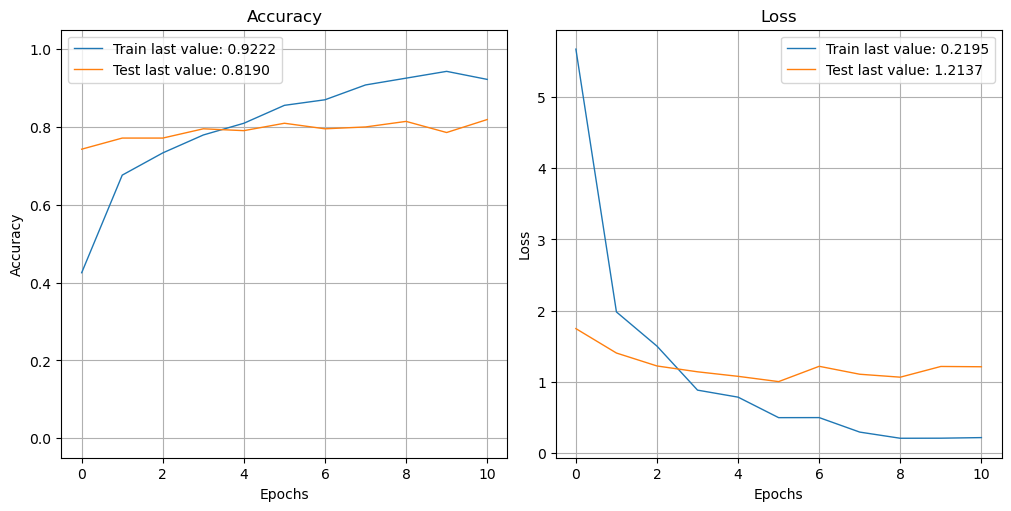

In [24]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [25]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)

print(f"{y_val_num}\n\n{y_val_pred}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 148s 22s/step
[3 6 2 6 3 5 4 0 0 2 6 0 1 5 6 3 1 1 6 0 1 2 6 3 3 0 4 4 2 0 2 4 6 5 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 1 5 4 5 0 2 6 5 5 1 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 1 5 3 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 3 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 0 2 0 3 2 4 5 3 1 3 3 0 0 4 2 1 6 1 1 4 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 1 3 1 4 5 6 5 0 4 0 6 1 0 4 0 2 1 4 0 2 4 0 5 2 4 0 1 0
 5 2 4 0 2 2 1 6 1 4 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]

[3 6 2 6 3 5 4 0 4 2 6 1 1 5 6 4 1 1 6 0 3 2 6 5 5 0 4 4 5 0 2 4 6 0 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 2 5 4 2 0 2 6 4 5 1 0 4 5 3 6 3 2 6 4 3 5 3 2 5 3
 3 3 3 6 1 5 3 4 2 0 0 5 2 6 3 4 3 4 6 1 2 0 0 1 6 3 3 1 1 5 3 1 1 1 2 1 3
 3 4 6 5 4 2 6 4 6 0 3 2 0 5 3 1 4 3 0 0 4 2 1 6 3 1 4 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 4 4 5 0 5 3 3 1 4 5 3 5 0 4 4 6 1 0 4 1 2 1 4 0 2 4 0 5 2 0 4 1 0
 5 2 4 0 2 2 1 6 1 0 2 4 3 2 6 6 2 0 6 0 4 0 6 5 5]


In [26]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[24  2  0  0  5  0  0]
 [ 0 26  2  3  0  0  1]
 [ 0  1 23  1  0  1  2]
 [ 2  0  1 21  3  3  0]
 [ 4  1  0  0 24  0  0]
 [ 2  0  1  2  1 24  1]
 [ 0  0  0  1  0  0 28]]


In [27]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [28]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

print(f"{conf_mat}\n\n{metrics.classification_report(y_val_num, y_val_pred_transform)}")

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[24  2  0  0  5  0  0]
 [ 0 26  2  3  0  0  1]
 [ 0  1 23  1  0  1  2]
 [ 2  0  1 21  3  3  0]
 [ 4  1  0  0 24  0  0]
 [ 2  0  1  2  1 24  1]
 [ 0  0  0  1  0  0 28]]

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        31
           1       0.87      0.81      0.84        32
           2       0.85      0.82      0.84        28
           3       0.75      0.70      0.72        30
           4       0.73      0.83      0.77        29
           5       0.86      0.77      0.81        31
           6       0.88      0.97      0.92        29

    accuracy                           0.81       210
   macro avg       0.81      0.81      0.81       210
weighted avg       0.81      0.81      0.81       210



<AxesSubplot:>

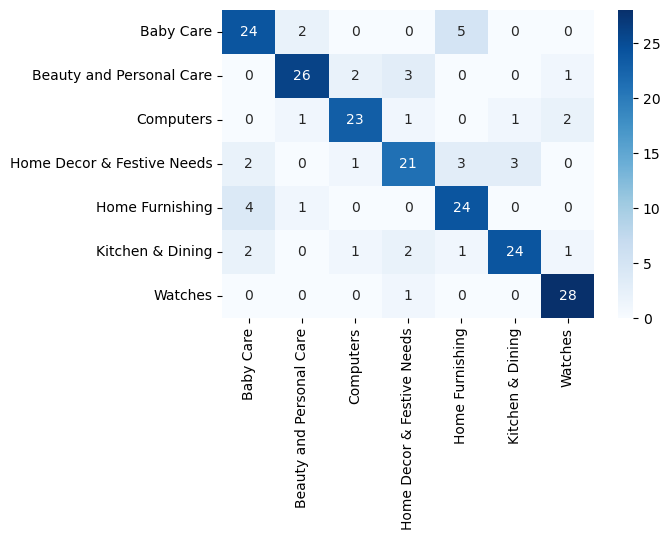

In [29]:
list_labels = data["label_name"].unique()

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in list_labels])

fmt='d'
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=fmt)

# Approche nouvelle par Dataset avec data augmentation intégrée au modèle

In [30]:
batch_size = 32
def dataset_fct(path, validation_split=0, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',          # Les labels sont inférés à partir des noms des sous-dossiers
        label_mode='categorical',   # Les labels sont retournés sous forme de tableau one-hot
        class_names=None,           # Les noms des classes sont automatiquement inférés des dossiers
        batch_size=batch_size,      # Taille du lot
        image_size=(224, 224),      # Taille des images après redimensionnement
        shuffle=True,               # Mélanger les données
        seed=42,                    # Graine pour la reproductibilité du mélange
        validation_split=validation_split,  # Pourcentage des données à utiliser pour la validation
        subset=data_type            # 'training' ou 'validation', selon que vous chargez les données d'entraînement ou de validation
    )
    return dataset


In [31]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [32]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [33]:
def create_model_fct2(num_classes) :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(num_classes, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


In [34]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct2(num_classes)

# Création du callback
model2_save_path = path_model + 'model2_best_weights_v1.keras'
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ ?                           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [36]:
with tf.device('/gpu:0'):
    history2 = model2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.1900 - loss: 2.0178 
Epoch 1: val_loss improved from inf to 1.48131, saving model to ./data/Model/model2_best_weights_v1.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 444s 22s/step - accuracy: 0.1928 - loss: 2.0129 - val_accuracy: 0.6190 - val_loss: 1.4813
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4388 - loss: 1.5623 
Epoch 2: val_loss improved from 1.48131 to 1.22989, saving model to ./data/Model/model2_best_weights_v1.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 418s 21s/step - accuracy: 0.4404 - loss: 1.5592 - val_accuracy: 0.6190 - val_loss: 1.2299
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5800 - loss: 1.3192 
Epoch 3: val_loss improved from 1.22989 to 1.16962, saving model to ./data/Model/model2_best_weights_v1.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 502s 25s/step - accuracy: 0.5802 - loss: 1.3166 - val_accuracy: 0.6095 - val_loss: 1.1696
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5960

In [37]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 230s 11s/step - accuracy: 0.8470 - loss: 0.4544
Training Accuracy   : 0.8651

7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.7445 - loss: 0.7668
Validation Accuracy :  0.7524


In [38]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7762
Test Accuracy       :  0.7571


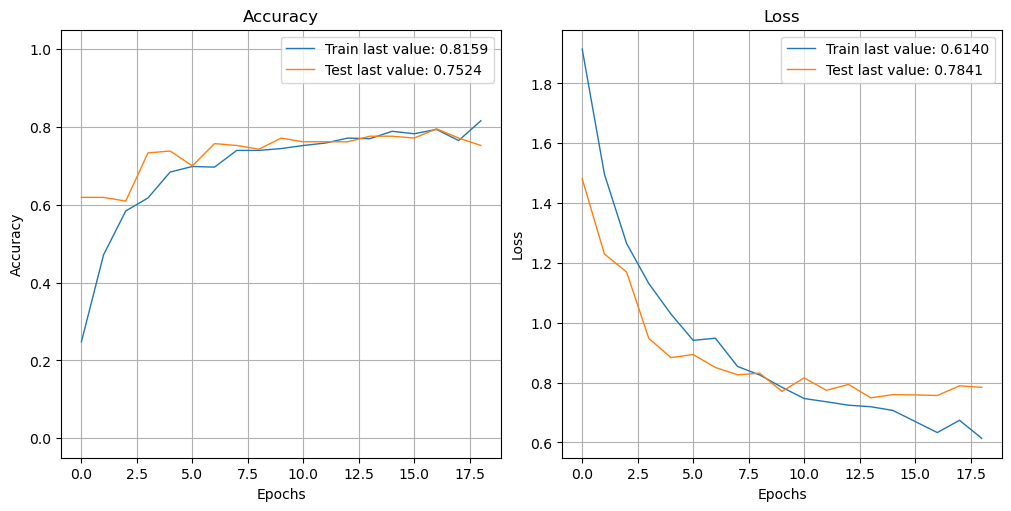

In [39]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [40]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model2.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)

print(f"{y_val_num}\n\n{y_val_pred}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 92s 13s/step
[3 6 2 6 3 5 4 0 0 2 6 0 1 5 6 3 1 1 6 0 1 2 6 3 3 0 4 4 2 0 2 4 6 5 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 1 5 4 5 0 2 6 5 5 1 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 1 5 3 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 3 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 0 2 0 3 2 4 5 3 1 3 3 0 0 4 2 1 6 1 1 4 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 1 3 1 4 5 6 5 0 4 0 6 1 0 4 0 2 1 4 0 2 4 0 5 2 4 0 1 0
 5 2 4 0 2 2 1 6 1 4 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]

[3 6 2 6 3 5 4 0 0 2 6 1 1 5 6 4 1 1 6 0 2 2 6 2 3 0 4 4 2 0 2 2 6 5 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 2 5 4 2 0 2 6 3 5 1 0 4 5 3 6 3 0 6 0 3 2 3 2 5 3
 3 3 2 6 1 5 6 4 2 0 3 5 2 2 3 4 3 4 6 1 2 0 0 1 6 3 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 4 3 0 3 2 4 5 3 1 0 3 0 0 4 2 1 6 3 1 0 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 4 3 1 4 5 6 5 0 4 4 6 1 0 4 0 2 1 4 4 2 4 0 5 5 4 4 1 0
 5 2 4 0 2 2 1 6 5 0 2 4 3 2 6 6 2 0 6 0 4 0 6 3 5]


In [41]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[26  1  0  0  4  0  0]
 [ 0 25  3  1  1  1  1]
 [ 0  0 26  1  0  1  0]
 [ 2  0  1 25  1  0  1]
 [ 3  1  1  0 24  0  0]
 [ 1  0  3  2  0 25  0]
 [ 0  0  0  0  0  0 29]]


In [42]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [43]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

print(f"{conf_mat}\n\n{metrics.classification_report(y_val_num, y_val_pred_transform)}")

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[26  1  0  0  4  0  0]
 [ 0 25  3  1  1  1  1]
 [ 0  0 26  1  0  1  0]
 [ 2  0  1 25  1  0  1]
 [ 3  1  1  0 24  0  0]
 [ 1  0  3  2  0 25  0]
 [ 0  0  0  0  0  0 29]]

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        31
           1       0.93      0.78      0.85        32
           2       0.76      0.93      0.84        28
           3       0.86      0.83      0.85        30
           4       0.80      0.83      0.81        29
           5       0.93      0.81      0.86        31
           6       0.94      1.00      0.97        29

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210



<AxesSubplot:>

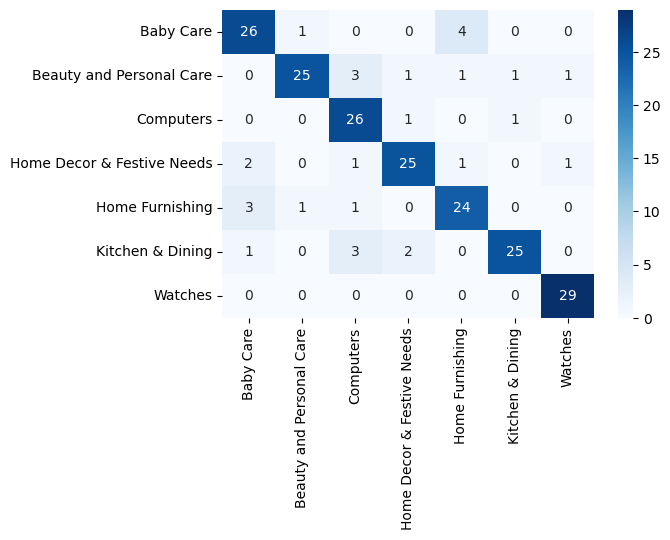

In [44]:
list_labels = data["label_name"].unique()

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in list_labels])

fmt='d'
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=fmt)